In [16]:
"""
astrojigs.py — Barnes–Hut N-body simulation (2D)

This module simulates self-gravitating particles in 2D using a Quadtree-based
Barnes–Hut approximation. It includes:

- Robust Quadtree with:
  • Consistent quadrant routing (ties handled), 
  • Incremental mass/COM updates at *all* nodes,
  • Standard opening criterion s/d < theta,
  • Softening to avoid singular forces,
  • Max-depth guard to avoid infinite subdivision when many bodies overlap.

- Symplectic Leapfrog (kick–drift–kick) integrator:
  Better long-term energy behavior than Euler.

- Dynamic, square root bounds each step (so the tree always encloses bodies).

- Optional plotting of particle positions and (optionally) the quadtree,
  and optional MP4 export (requires OpenCV).

Author: Jigar Patel :)
"""

from __future__ import annotations

import math
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# OpenCV is optional; guard its use
try:
    import cv2  # type: ignore
    _HAS_CV2 = True
except Exception:  # pragma: no cover
    cv2 = None
    _HAS_CV2 = False


# ---------------------------------------------------------------------
# Data structures
# ---------------------------------------------------------------------

@dataclass
class Point:
    """
    A particle in 2D.

    Parameters
    ----------
    x, y : float
        Position (Cartesian).
    mass : float, default 1.0
        Particle mass.
    vx, vy : float, default 0.0
        Velocity components.
    color : Optional[str], default None
        Color tag for plotting (unused by solver).
    """
    x: float
    y: float
    mass: float = 1.0
    vx: float = 0.0
    vy: float = 0.0
    color: Optional[str] = None


class Rectangle:
    """
    Axis-aligned rectangle, defined by center and size.

    Notes
    -----
    - Uses inclusive containment on left/bottom and right/top edges to avoid
      gaps. Combined with consistent tie-breaking in the quadtree, that prevents
      insert loops.
    """

    def __init__(self, cx: float, cy: float, w: float, h: float):
        self.x = float(cx)
        self.y = float(cy)
        self.w = float(w)
        self.h = float(h)
        self.west = self.x - self.w / 2.0
        self.east = self.x + self.w / 2.0
        self.south = self.y - self.h / 2.0
        self.north = self.y + self.h / 2.0

    def contains(self, p: Point) -> bool:
        """Return True iff point is inside this rectangle (inclusive edges)."""
        return (
            self.west <= p.x <= self.east and
            self.south <= p.y <= self.north
        )

    def draw(self, ax, color: str = "red", lw: float = 1.0):
        """Draw the rectangle outline on a Matplotlib axis."""
        ax.plot(
            [self.west, self.east, self.east, self.west, self.west],
            [self.north, self.north, self.south, self.south, self.north],
            c=color, lw=lw,
        )


class Quadtree:
    """
    Quadtree for Barnes–Hut gravity.

    Parameters
    ----------
    boundary : Rectangle
        Spatial extent (must enclose all bodies to be inserted).
    G : float
        Gravitational constant (simulation units).
    theta : float
        Barnes–Hut opening angle threshold (use cell as monopole if s/d < theta).
        Typical values: 0.5–0.8 (smaller = more accurate, slower).
    capacity : int, default 1
        Bodies to store before subdividing a node.
    eps : float, default 1e-3
        Plummer-like softening length used in force calculation (adds eps^2 to r^2).
    max_depth : int, default 32
        Maximum subdivision depth to guard against infinite splitting when many
        bodies share nearly identical coordinates.

    Notes
    -----
    - Mass and center-of-mass (COM) are updated *incrementally* at each node
      during insertion, so internal nodes always have correct monopole values.
    - Opening criterion uses the node's full side length (max of w,h).
    """

    __slots__ = (
        "boundary", "G", "theta", "capacity", "eps", "max_depth",
        "mass", "comx", "comy",
        "points", "children", "divided"
    )

    def __init__(self,
                 boundary: Rectangle,
                 G: float,
                 theta: float,
                 capacity: int = 1,
                 eps: float = 1e-3,
                 max_depth: int = 32):
        self.boundary = boundary
        self.G = float(G)
        self.theta = float(theta)
        self.capacity = int(capacity)
        self.eps = float(eps)
        self.max_depth = int(max_depth)

        self.mass: float = 0.0
        self.comx: float = 0.0
        self.comy: float = 0.0

        self.points: List[Point] = []
        self.children: List[Optional[Quadtree]] = [None, None, None, None]
        self.divided: bool = False

    # ---------------------- Node helpers ----------------------

    def _quad_index(self, x: float, y: float) -> int:
        """
        Determine which child quadrant (0..3) the coordinate (x,y) belongs to.

        Quadrants are:
            0: top-left,  1: top-right,  2: bottom-left,  3: bottom-right

        Tie-breaking:
            - x <= center goes left; x  > center goes right
            - y  > center goes top;  y <= center goes bottom
        """
        left = (x <= self.boundary.x)
        top = (y > self.boundary.y)
        if  top and  left: return 0
        if  top and not left: return 1
        if (not top) and left: return 2
        return 3

    def _child_bounds(self, qi: int) -> Rectangle:
        """Return Rectangle bounds for child quadrant index qi."""
        h2 = self.boundary.h * 0.5
        w2 = self.boundary.w * 0.5
        cx, cy = self.boundary.x, self.boundary.y
        if qi == 0:   # top-left
            return Rectangle(cx - w2/2.0, cy + h2/2.0, w2, h2)
        if qi == 1:   # top-right
            return Rectangle(cx + w2/2.0, cy + h2/2.0, w2, h2)
        if qi == 2:   # bottom-left
            return Rectangle(cx - w2/2.0, cy - h2/2.0, w2, h2)
        return Rectangle(cx + w2/2.0, cy - h2/2.0, w2, h2)

    def _ensure_child(self, qi: int) -> "Quadtree":
        """Create child node `qi` on demand and return it."""
        if self.children[qi] is None:
            self.children[qi] = Quadtree(
                self._child_bounds(qi),
                G=self.G, theta=self.theta,
                capacity=self.capacity, eps=self.eps,
                max_depth=self.max_depth
            )
        return self.children[qi]

    # ---------------------- Public API ----------------------

    def insert(self, p: Point, depth: int = 0) -> bool:
        """
        Insert a point into the tree (updates mass/COM on the way down).

        Returns
        -------
        bool
            True if the point was inserted into this subtree; False if outside.
        """
        if not self.boundary.contains(p):
            return False

        # Incremental mass/COM update at every visited node.
        M_old = self.mass
        self.mass = M_old + p.mass
        if self.mass > 0.0:
            self.comx = (self.comx * M_old + p.mass * p.x) / self.mass
            self.comy = (self.comy * M_old + p.mass * p.y) / self.mass

        # If below capacity or at max depth, keep as leaf storage.
        if (not self.divided) and (len(self.points) < self.capacity or depth >= self.max_depth):
            self.points.append(p)
            return True

        # Need to subdivide?
        if not self.divided:
            self._subdivide_and_push_down(depth)

        # Route to one child.
        qi = self._quad_index(p.x, p.y)
        return self._ensure_child(qi).insert(p, depth + 1)

    def _subdivide_and_push_down(self, depth: int):
        """Split node into 4 children and push existing points into children."""
        self.divided = True
        old_points = self.points
        self.points = []
        for p in old_points:
            qi = self._quad_index(p.x, p.y)
            self._ensure_child(qi).insert(p, depth + 1)

    def calculate_force(self, p: Point) -> Tuple[float, float]:
        """
        Compute gravitational force on point `p` from this node.

        Returns
        -------
        (fx, fy) : tuple of floats
            Net force components on `p`.

        Notes
        -----
        - Uses Plummer-like softening: r^2 -> r^2 + eps^2.
        - For leaf nodes, sums exact forces from contained particles (skipping `p`).
        - For internal nodes, applies Barnes–Hut opening test (s/d < theta) to
          decide whether to approximate with this node's monopole or to open
          and recurse into children.
        """
        if self.mass == 0.0:
            return 0.0, 0.0

        # Vector from p to node COM
        dx = self.comx - p.x
        dy = self.comy - p.y
        r2 = dx*dx + dy*dy + self.eps*self.eps

        if not self.divided:
            # Leaf: direct-sum contributions from stored points (small list)
            fx = fy = 0.0
            for q in self.points:
                if q is p:
                    continue
                qdx = q.x - p.x
                qdy = q.y - p.y
                qr2 = qdx*qdx + qdy*qdy + self.eps*self.eps
                invr3 = 1.0 / (qr2 * math.sqrt(qr2))
                s = self.G * p.mass * q.mass * invr3
                fx += s * qdx
                fy += s * qdy
            return fx, fy

        # Internal node: Barnes–Hut opening criterion
        d = math.sqrt(r2)
        s = max(self.boundary.w, self.boundary.h)  # full side length
        if s / d < self.theta:
            invr3 = 1.0 / (r2 * d)
            sG = self.G * p.mass * self.mass * invr3
            return sG * dx, sG * dy

        fx = fy = 0.0
        for ch in self.children:
            if ch is not None and ch.mass > 0.0:
                cx, cy = ch.calculate_force(p)
                fx += cx
                fy += cy
        return fx, fy

    def draw(self, ax):
        """Recursively draw node bounds for debugging/visualization."""
        self.boundary.draw(ax)
        if self.divided:
            for ch in self.children:
                if ch is not None:
                    ch.draw(ax)


# ---------------------------------------------------------------------
# Simulation utilities
# ---------------------------------------------------------------------

def _make_square_bounds(points: List[Point], pad: float = 1.05) -> Rectangle:
    """
    Construct a square Rectangle that encloses all points, padded by `pad`.

    Returns
    -------
    Rectangle
        Dynamic root bounds for the quadtree.
    """
    xs = [p.x for p in points]
    ys = [p.y for p in points]
    xmin, xmax = min(xs), max(xs)
    ymin, ymax = min(ys), max(ys)
    cx = 0.5 * (xmin + xmax)
    cy = 0.5 * (ymin + ymax)
    half = 0.5 * max(xmax - xmin, ymax - ymin)
    if half <= 0.0:
        half = 1.0
    half *= pad
    return Rectangle(cx, cy, 2.0 * half, 2.0 * half)


def _compute_accelerations(points: List[Point], tree: Quadtree) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute accelerations for all points using the given tree.

    Returns
    -------
    ax, ay : np.ndarray
        Arrays of accelerations per particle.
    """
    N = len(points)
    ax = np.zeros(N, dtype=np.float64)
    ay = np.zeros(N, dtype=np.float64)
    for i, p in enumerate(points):
        fx, fy = tree.calculate_force(p)
        ax[i] = fx / p.mass
        ay[i] = fy / p.mass
    return ax, ay


def barnes_hut_sim(points: List[Point],
                   *,
                   dt: float = 1.0,
                   G: float = 0.1,
                   theta: float = 0.6,
                   eps: float = 1e-3,
                   capacity: int = 1,
                   max_depth: int = 32,
                   n_frames: int = 200,
                   draw_quadtree: bool = False,
                   fixed_viewport: Optional[Tuple[float, float, float, float]] = None,
                   save_to_video: Optional[str] = None,
                   video_fps: int = 30):
    """
    Run a Barnes–Hut N-body simulation and render frames.

    Parameters
    ----------
    points : list[Point]
        Bodies to simulate (positions/velocities are updated *in-place*).
    dt : float, default 1.0
        Time step.
    G : float, default 0.1
        Gravitational constant (simulation units).
    theta : float, default 0.6
        Opening angle threshold; smaller = more accurate, slower.
    eps : float, default 1e-3
        Softening length (adds eps^2 to r^2).
    capacity : int, default 1
        Max bodies per leaf before subdivision.
    max_depth : int, default 32
        Maximum tree depth (guard against infinite splits).
    n_frames : int, default 200
        Number of frames/steps to simulate.
    draw_quadtree : bool, default False
        If True, overlay quadtree bounds (expensive; for debugging).
    fixed_viewport : (xmin, xmax, ymin, ymax) or None, default None
        If provided, use fixed axes; otherwise auto-fit dynamically.
    save_to_video : str or None, default None
        If provided, path to save MP4 (requires OpenCV).
    video_fps : int, default 30
        Frames per second for video export.

    Notes
    -----
    - Uses leapfrog (KDK): half-kick → drift → rebuild tree → full accelerations
      → half-kick. This keeps energy drift bounded compared to Euler.
    - Close your figures each step to avoid memory bloat when producing many frames.
    """
    # Video writer (optional)
    out = None
    if save_to_video is not None:
        if not _HAS_CV2:
            raise RuntimeError("OpenCV (cv2) not available but save_to_video was provided.")
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        # We'll render 1000x1000 like your original example; feel free to change
        out = cv2.VideoWriter(save_to_video, fourcc, video_fps, (1000, 1000))

    # Build initial tree from positions; compute initial accelerations
    root_bounds = _make_square_bounds(points)
    tree = Quadtree(root_bounds, G=G, theta=theta, capacity=capacity, eps=eps, max_depth=max_depth)
    for p in points:
        tree.insert(p)
    ax, ay = _compute_accelerations(points, tree)

    for t in range(n_frames):
        # Half-kick (leapfrog)
        for i, p in enumerate(points):
            p.vx += 0.5 * dt * ax[i]
            p.vy += 0.5 * dt * ay[i]

        # Drift
        for p in points:
            p.x += dt * p.vx
            p.y += dt * p.vy

        # Rebuild tree at new positions (dynamic square bounds)
        root_bounds = _make_square_bounds(points)
        tree = Quadtree(root_bounds, G=G, theta=theta, capacity=capacity, eps=eps, max_depth=max_depth)
        for p in points:
            tree.insert(p)

        # New accelerations
        ax, ay = _compute_accelerations(points, tree)

        # Half-kick
        for i, p in enumerate(points):
            p.vx += 0.5 * dt * ax[i]
            p.vy += 0.5 * dt * ay[i]

        # ---- Render frame ----
        fig, axp = plt.subplots(figsize=(10, 10))
        xs = [p.x for p in points]
        ys = [p.y for p in points]
        axp.scatter(xs, ys, s=1, c="black")

        if draw_quadtree:
            tree.draw(axp)

        if fixed_viewport is not None:
            xmin, xmax, ymin, ymax = fixed_viewport
        else:
            xmin, xmax = min(xs), max(xs)
            ymin, ymax = min(ys), max(ys)
            # Add a small padding for aesthetics
            dx = max(1e-6, 0.05 * max(1.0, xmax - xmin))
            dy = max(1e-6, 0.05 * max(1.0, ymax - ymin))
            xmin -= dx; xmax += dx
            ymin -= dy; ymax += dy

        axp.set_xlim(xmin, xmax)
        axp.set_ylim(ymin, ymax)
        axp.set_aspect("equal", adjustable="box")
        axp.axis("off")
        plt.tight_layout()

        # If writing to video, capture the canvas
        if out is not None:
            fig.canvas.draw()
            data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            frame = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

        # Show (or omit) interactive display; clear to keep notebook tidy
        plt.show()
        plt.close(fig)
        print(f"Frame: {t + 1}/{n_frames}")
        clear_output(wait=True)

    if out is not None:
        out.release()


# ---------------------------------------------------------------------
# Diagnostics (optional)
# ---------------------------------------------------------------------

def total_momentum(points: List[Point]) -> Tuple[float, float]:
    """
    Compute total linear momentum (px, py).
    """
    px = sum(p.mass * p.vx for p in points)
    py = sum(p.mass * p.vy for p in points)
    return px, py


def kinetic_energy(points: List[Point]) -> float:
    """
    Compute total kinetic energy (sum 1/2 m v^2).
    """
    return 0.5 * sum(p.mass * (p.vx * p.vx + p.vy * p.vy) for p in points)


def potential_energy(points: List[Point], G: float = 0.1, eps: float = 1e-3) -> float:
    """
    Compute pairwise gravitational potential energy (O(N^2), for diagnostics).

    Parameters
    ----------
    G : float
        Gravitational constant.
    eps : float
        Softening length (adds eps^2 to r^2).

    Notes
    -----
    This is expensive for large N; use sparingly for sanity checks.
    """
    U = 0.0
    N = len(points)
    for i in range(N):
        pi = points[i]
        for j in range(i + 1, N):
            pj = points[j]
            dx = pj.x - pi.x
            dy = pj.y - pi.y
            r = math.hypot(dx, dy)
            U -= G * pi.mass * pj.mass / math.sqrt(r * r + eps * eps)
    return U


# ---------------------------------------------------------------------
# Example usage
# ---------------------------------------------------------------------

# if __name__ == "__main__":
#     # Example: 100 equal-mass bodies with random positions in a box.
#     rng = np.random.default_rng(42)
#     n_stars = 100
#     width, height = 100.0, 100.0

#     pts = [
#         Point(
#             x=float(rng.uniform(0.1 * width, 0.9 * width)),
#             y=float(rng.uniform(0.1 * height, 0.9 * height)),
#             mass=1.0,
#             vx=float(rng.normal(0.0, 0.1)),
#             vy=float(rng.normal(0.0, 0.1)),
#         )
#         for _ in range(n_stars)
#     ]

#     # Fixed viewport (optional): keep camera framing steady
#     fixed = (0.0, width, 0.0, height)

#     barnes_hut_sim(
#         pts,
#         dt=0.5,
#         G=0.1,
#         theta=0.6,
#         eps=1e-2,
#         capacity=1,
#         max_depth=32,
#         n_frames=200,
#         draw_quadtree=False,           # set True to debug BH cells
#         fixed_viewport=fixed,          # or None for auto-fit
#         save_to_video=None,            # e.g. "barnes_hut.mp4"
#         video_fps=30,
#     )

#     # Diagnostics example (optional)
#     KE = kinetic_energy(pts)
#     # PE = potential_energy(pts, G=0.1, eps=1e-2)  # O(N^2), expensive for large N
#     PX, PY = total_momentum(pts)
#     print(f"Final KE ~ {KE:.4f}, total momentum ~ ({PX:.4e}, {PY:.4e})")


In [17]:
def get_cart_coords(r,theta):
    """
    Convert r, theta to x,y
    """
    return r*np.cos(np.deg2rad(theta)), r*np.sin(np.deg2rad(theta))

def get_cart_coords_vel(rv, thetav, r, theta):
    """
    Convert velocities:
    [dr/dt, dtheta/dt] to [dx/dt,dy/dt]
    """
    vx = rv*np.cos(np.deg2rad(theta)) - r*np.sin(np.deg2rad(theta))*thetav
    vy = rv*np.sin(np.deg2rad(theta)) + r*np.cos(np.deg2rad(theta))*thetav
    return vx, vy

In [18]:
def make_exponential_disk(
    n_total: int = 400,
    R_d: float = 8.0,
    R_max: float = 40.0,
    M_total: float = 400.0,
    G_used: float = 0.1,
    bulge_frac: float = 0.15,
    bulge_sigma: float = 2.0,
    rot_sign: int = +1,
    v_disp: float = 0.05,
    seed: int = 7,
) -> list[Point]:
    """
    Galaxy-like ICs: exponential disk (Σ∝e^{-r/R_d}) + small Gaussian bulge.
    - Samples disk radii via Erlang k=2 trick (r = R_d*(E1+E2)).
    - Sets approximate circular velocities from M(<r) of disk+bulge.
    - Adds a tiny velocity dispersion to keep it from being perfectly cold.
    """
    import numpy as np
    rng = np.random.default_rng(seed)
    n_bulge = int(bulge_frac * n_total)
    n_disk  = n_total - n_bulge
    m = M_total / n_total
    pts: list[Point] = []

    # Bulge (2D Gaussian)
    if n_bulge > 0:
        xb = rng.normal(0.0, bulge_sigma, size=n_bulge)
        yb = rng.normal(0.0, bulge_sigma, size=n_bulge)
        vxb = rng.normal(0.0, v_disp, size=n_bulge)
        vyb = rng.normal(0.0, v_disp, size=n_bulge)
        for i in range(n_bulge):
            pts.append(Point(float(xb[i]), float(yb[i]), mass=m,
                             vx=float(vxb[i]), vy=float(vyb[i])))

    # Disk (Σ ∝ e^{-r/Rd} → p(r) ∝ r e^{-r/Rd}; sample with Erlang k=2)
    e1 = rng.exponential(1.0, size=n_disk)
    e2 = rng.exponential(1.0, size=n_disk)
    r = R_d * (e1 + e2)
    r = np.clip(r, 0.0, R_max)
    th = rng.uniform(0, 2*np.pi, size=n_disk)
    xd, yd = r*np.cos(th), r*np.sin(th)

    # Approx enclosed mass: disk + cored bulge
    M_disk  = M_total * (1.0 - bulge_frac)
    M_bulge = M_total * bulge_frac
    a = 2.5 * bulge_sigma + 1e-6
    M_enc = M_disk * (1.0 - np.exp(-r/R_d)*(1.0 + r/R_d)) + M_bulge * (r**2/(r**2 + a**2))

    # Circular speed (avoid div-by-zero near center)
    v_c = np.sqrt(np.maximum(0.0, G_used * M_enc / np.maximum(r, 0.5)))

    # Tangential directions
    tx, ty = rot_sign * (-np.sin(th)), rot_sign * (np.cos(th))
    vxd = v_c * tx + rng.normal(0.0, v_disp, size=n_disk)
    vyd = v_c * ty + rng.normal(0.0, v_disp, size=n_disk)

    for i in range(n_disk):
        pts.append(Point(float(xd[i]), float(yd[i]), mass=m,
                         vx=float(vxd[i]), vy=float(vyd[i])))
    return pts


In [22]:
660/30

22.0

In [27]:
G_sim = 0.1
pts = make_exponential_disk(
    n_total=360,
    R_d=7.0,
    R_max=35.0,
    M_total=360.0,
    G_used=G_sim,
    bulge_frac=0.18,
    bulge_sigma=2.0,
    rot_sign=+1,    # flip to -1 for clockwise
    v_disp=0.08,
    seed=42,
)

barnes_hut_sim(
    pts,
    dt=0.06,
    G=G_sim,
    theta=0.6,
    eps=0.15,
    capacity=1,
    max_depth=32,
    n_frames=640,            # bump up for longer runs
    draw_quadtree=False,
    fixed_viewport=(-45, 45, -45, 45),
    save_to_video="./Outputs/Barnes-Hut/ep2.mp4",      # set e.g. "/mnt/data/galaxy.mp4" if cv2 is available
    video_fps=30

)

print("Final KE:", kinetic_energy(pts), "Total momentum:", total_momentum(pts))


Final KE: 378.1153921521314 Total momentum: (np.float64(-8.564875357058613), np.float64(1.3100647422848162))


## Second Sample:

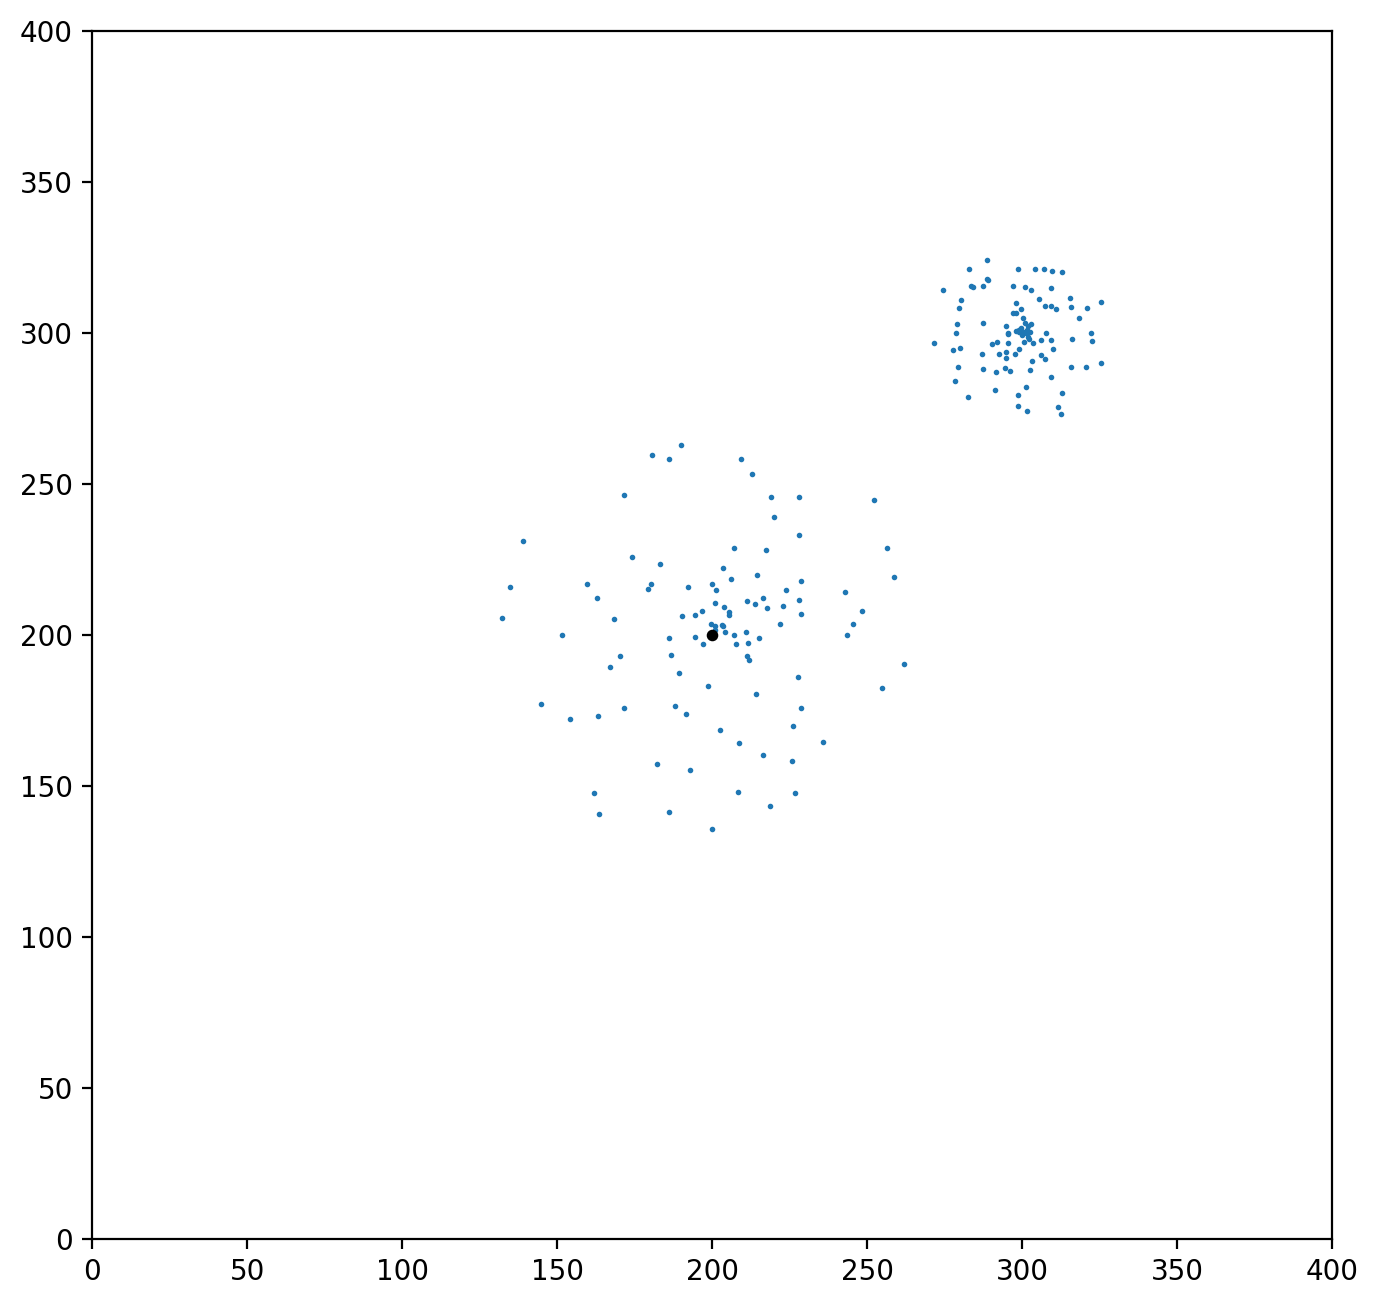

In [829]:
qt = Quadtree(boundary,G=1,theta_=0.5,n=1)
for p in points:
    qt.insert(p)

plt.figure(figsize=(8,8),dpi=200)
plt.scatter([p.x for p in points], [p.y for p in points],s=1)
# plt.scatter(qt.quads[2].center_of_mass()[0],qt.quads[2].center_of_mass()[0])
# Center of mass for the entire quadrant:
#plt.scatter(qt.center_of_mass_x/qt.mass, qt.center_of_mass_y/qt.mass, s=200, c='green')
pov = points[0]
plt.scatter(pov.x,pov.y,color='black',s=10)
# qt.show_from_point(pov,show_mass=True)
# qt.show(show_entire=False)
plt.xlim(qt.boundary.x - qt.boundary.w/2,qt.boundary.x+qt.boundary.w/2)
plt.ylim(qt.boundary.y-qt.boundary.h/2,qt.boundary.y+qt.boundary.h/2)
plt.show()

In [675]:
qt.boundary.x

200.0

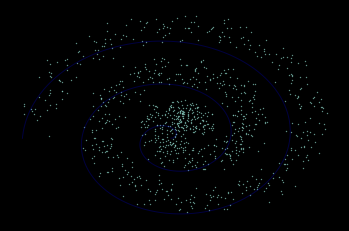

In [152]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('dark_background')  
fig, ax = plt.subplots()

# Generate x and y coordinates for the spiral pattern
theta = np.linspace(0, 5 * np.pi, 1000)
r = np.linspace(0, 1, 1000)
x = r * np.cos(theta)
y = r * np.sin(theta)

x_init = []
y_init = []

for i in range(1000):
    x_init.append(x[i] + 0.25*np.random.rand())
    y_init.append(y[i] + 0.25*np.random.rand())

# Plot the spiral pattern
ax.plot(x,y,color='blue',linewidth=1,alpha=0.25)
ax.scatter(x_init, y_init, s=0.1)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.show()

In [ ]:
theta = np.linspace(0, 5 * np.pi, 1000)
r = np.linspace(0, 1, 1000)
x = r * np.cos(theta)
y = r * np.sin(theta)

x_init = []
y_init = []

for i in range(1000):
    x_init.append(x[i] + 0.25*np.random.rand())
    y_init.append(y[i] + 0.25*np.random.rand())

<ipython-input-62-f7ca8dd2858f>:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


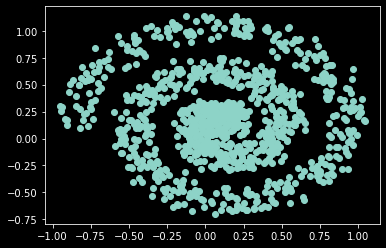

In [62]:
fig, ax = plt.subplots()
ax.scatter(x_init, y_init)

# Convert the figure to a numpy array
fig.canvas.draw()
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [65]:
data.shape

(288, 432, 3)

In [6]:
def plummer_density_profile(n, r_scale):
    """
    Returns x and y coordinates, and x and y velocities of n stars using the Plummer density profile

    Parameters:
    n (int): Number of stars to generate
    r_scale (float): Scale radius of the Plummer density profile

    Returns:
    x, y, vx, vy (np.ndarray): x and y coordinates, and x and y velocities of the stars
    """
    r = np.random.uniform(0, r_scale, n)
    theta = np.random.uniform(0, 2 * np.pi, n)
    x = r * np.cos(theta) / (1 + (r/r_scale)**2)**0.5
    y = r * np.sin(theta) / (1 + (r/r_scale)**2)**0.5
    v_r = -1 * (r_scale**2 + r**2)**(-0.5) * r / (r_scale**2 + r**2)**0.5
    v_theta = (r_scale**2 + r**2)**(-0.5)
    vx = v_r * np.cos(theta) - v_theta * np.sin(theta)
    vy = v_r * np.sin(theta) + v_theta * np.cos(theta)
    return x, y, vx, vy

In [7]:

def plummer_density_profile_with_mass(n, r_scale, mass,G, center=(0, 0)):
    """
    Returns x and y coordinates, and x and y velocities of n stars using the Plummer density profile with mass

    Parameters:
    n (int): Number of stars to generate
    r_scale (float): Scale radius of the Plummer density profile
    mass (float): Mass of the central object
    center (tuple): (x, y) position of the center of the Plummer sphere

    Returns:
    x, y, vx, vy (np.ndarray): x and y coordinates, and x and y velocities of the stars
    """
    r = np.random.uniform(0, r_scale, n)
    theta = np.random.uniform(0, 2 * np.pi, n)
    x = center[0] + r * np.cos(theta) / (1 + (r/r_scale)**2)**0.5
    y = center[1] + r * np.sin(theta) / (1 + (r/r_scale)**2)**0.5
    v_circ = (G * mass / r)**0.5
    vx = v_circ * np.sin(theta)
    vy = -1 * v_circ * np.cos(theta)
    return x, y, vx, vy

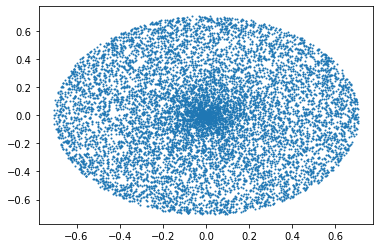

In [19]:
x,y,vx,vy= plummer_density_profile(10000,1)

plt.scatter(x,y,s=1)

# Using the `Plummer_density_profile` to sort out a galaxy

### Some parameters:
mass = solar mass

distance = light year (average diameter of galaxy = 105,700 ly)

Gravitaitonal Constant = G = $\dfrac{ly^3}{solar mass \times millionyears^2}$

In [4]:
from astropy import constants

In [5]:
import astropy

In [6]:
astropy.units.M_sun

Unit("solMass")

In [11]:
np.square((1000000*astropy.units.yr).decompose())

<Quantity 9.95882118e+26 s2>

In [12]:
constants.G.to_value((astropy.units.lyr.decompose())**3/((astropy.units.M_sun.decompose())*(np.square((1000000*astropy.units.yr).decompose()))))

0.1560793896760612

In [45]:
import astropy
from astropy import constants as astropy_constants
class constants:
    """
    Stores constants
    
    constants.info() : gives information about each term in units being used:
    
    Use the following terms in the corresponding 1 unit:
    
    distance : 1 Light year
    time : 1 Million year
    Mass : Solar Masses
    G : 0.156079 ly^3/(solar_mass x million_year^2)
    """
    
    G = astropy_constants.G.to_value((astropy.units.lyr.decompose())**3/((astropy.units.M_sun.decompose())*(np.square((1000000*astropy.units.yr).decompose()))))
    def info():
        print("distance : 1 Light year\ntime : 1 Million year\nMass : Solar Masses\nG : 0.156079 ly^3/(solar_mass x million_year^2)")

In [46]:
constants.G
constants.info()

distance : 1 Light year
time : 1 Million year
Mass : Solar Masses
G : 0.156079 ly^3/(solar_mass x million_year^2)


In [14]:
constants.info()

distance : 1 Light year
time : 1 Million year
Mass : Solar Masses
G : 0.156079 ly^3/(solar_mass x million_year^2)


In [14]:
G = constants.G.to_value((astropy.units.lyr)**3/((astropy.units.M_sun)*(np.square((1000000*astropy.units.yr)))))

In [15]:
G

0.15607938967606114

In [51]:
np.zeros(2**56)

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

In [ ]:
# Rectangle (boundary) specs
width = 105700
height = 105700
center_x = width/2
center_y = height/2
boundary = Rectangle(center_x-0.01,center_y-0.01,width,height)


# New points
points = []
black_hole_point = Point(center_x,center_y, mass= 4.15e6,vx=0,vy=0)
# black hole at center
points.append(black_hole_point)

x,y,vx,vy = plummer_density_profile_with_mass(n=1200,
                                              r_scale=(width-width*0.5),
                                              mass=black_hole_point.mass,
                                              G=G,
                                              center=(center_x,center_y))


for i in range(len(x)):
    points.append(Point(x[i], y[i],
                        mass = np.random.uniform(0.4,1.8),
                        vx = vx[i], vy = vy[i]))


barnes_hut_sim(points,
               g_const=G,
               dt=1,theta=1,
               n_frames=100000,save_to_video="plummer_8_120fps_final_rip_pc_4.mp4")

frame: 258/100000
